# 骚扰号码分析的探索结果 

##  本文提纲
  1. 利用有监督学习进行分类
     - 整理数据
     - 利用筛选以后的数据训练分类器并评估
     - 把分类器用在没筛选过的数据上
  2. 半监督学习进行分类
  3. 结论
  4. 下一步做什么

## 1. 利用有监督学习进行分类

###  整理数据

如之前讨论的,先给负样本打标签,然后基于所打的标签做分类器

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc


positive = pd.read_csv('./positive.csv',encoding='gbk')
positive['label']= 1 # 骚扰号码标记为1
negative = pd.read_csv('./negative.csv',encoding='gbk')
negative['label'] = 0# 非骚扰号码标记为0
#去掉 手机号列,去掉不太用得上的漫游相关字段
to_drop = ['手机号码','漫游通话时长（单位：秒）','漫游通话次数']
l=[] # 去掉几点通话字段,共24个
for i in range(25):
    l.append(str(i)+'点通话')  
    
to_drop.extend(l)

positive = positive.drop(to_drop,axis = 1 )
negative = negative.drop(to_drop,axis = 1 )

D:\develop\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# 过滤False Negative和False Positive
# 有些骚扰号码估计已经金盆洗手了,没有很明显的骚扰特征了,把它们用一个规则过滤掉
# 同样,非骚扰号码里也有混在里面的骚扰户,这里用规则过滤一下

positive['avg']= positive.iloc[:, 17:27].sum(axis=1)/10
negative['avg']= negative.iloc[:, 17:27].sum(axis=1)/10
positive = positive[positive['avg']>5] # 8点到18点,平均每个小时通话次数大于5
negative = negative.sort_values('avg').iloc[:int(len(negative)*0.6),:] # 8点到18点,平均通话小时数最小的前60%

In [3]:

df = pd.concat([positive,negative]) 
# 定义一个次均通话时长

df['次均通话时长'] = df['月通话时长（单位：秒）']/df['月通话次数']
#df['次均漫游时长'] = df['漫游通话时长（单位：秒）']/df['漫游通话次数']
df = df.fillna(0) # 填补缺失值为 0 
df.replace([np.inf, -np.inf], 0)

# 经过多次选取特征并降维做散点图后,选出以下属性,效果相对较好
y = df['label']
df = df[['次均通话时长','在网时长（单位：秒）','当月活跃基站个数','交往圈数量']]


start pca...


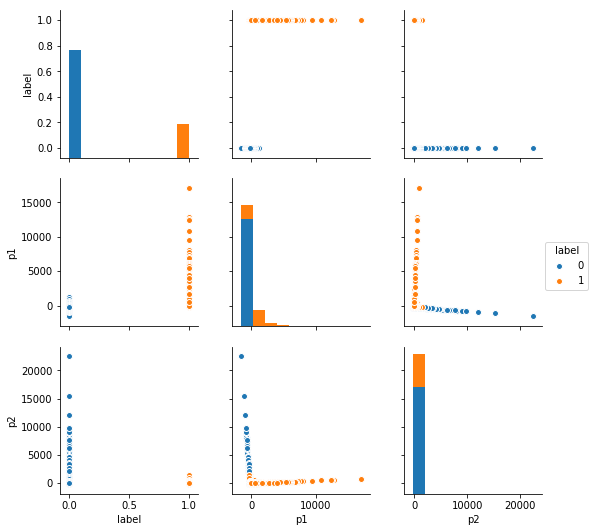

In [4]:
print('start pca...')
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(df)
reduced_X_1 = reduced_X[:,0]

reduced_X_2 = reduced_X[:,1]

conponent = pd.DataFrame({'p1':reduced_X_1,'p2':reduced_X_2,'label':y})
X = conponent[['p1','p2']]
y = conponent['label']
sns.pairplot(conponent,hue='label')

从图里可以看到,两类号码已经有明显的分界线了,采用常见的分类方法进行分类,用recall作为评价标准(宁可错杀一万,不可放过一个),能更广的覆盖骚扰号码.
这里我们就用简单的随机森林做个分类.

start trainning...
Cross-validation (recall) 0.950432500618


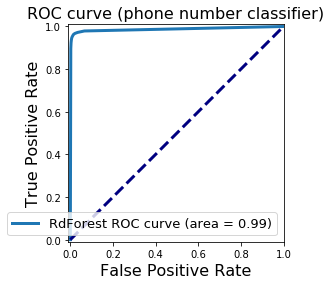

In [5]:
# 随机森林
clf = RandomForestClassifier(n_estimators=10, max_depth=None,
     min_samples_split=2, random_state=0)

print('start trainning...')

# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=5, scoring = 'recall').mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
#做出ROC曲线
y_score_lr = clf.fit(X_train, y_train).predict_proba(X_test)
y_score_lr = y_score_lr[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='RdForest ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (phone number classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

从ROC曲线来看,效果不错,基于我们手动划分的骚扰号码和非骚扰号码,AUC很高(最高为1),recall是0.950432500618,意味着平均能找出95%的骚扰号码

### 30万全部的数据集上测试分类器

之前的数据集我们做了一些手动的过滤,要是不过滤,我们在上面做一个分类,效果怎么样呢?可以预期比上面的95%要低,因为本来就有很多假正例和假负例混在里面

In [6]:
positive = pd.read_csv('./positive.csv',encoding='gbk')
positive['label']= 1 # 骚扰号码标记为1
negative = pd.read_csv('./negative.csv',encoding='gbk')
negative['label'] = 0# 非骚扰号码标记为0
#去掉 手机号列,去掉不太用得上的漫游相关字段
to_drop = ['手机号码','漫游通话时长（单位：秒）','漫游通话次数']
l=[] # 去掉几点通话字段,共24个
for i in range(25):
    l.append(str(i)+'点通话')  
    
to_drop.extend(l)

positive = positive.drop(to_drop,axis = 1 )
negative = negative.drop(to_drop,axis = 1 )
positive['avg']= positive.iloc[:, 17:27].sum(axis=1)/10
negative['avg']= negative.iloc[:, 17:27].sum(axis=1)/10
df = pd.concat([positive,negative]) 
# 定义一个次均通话时长

df['次均通话时长'] = df['月通话时长（单位：秒）']/df['月通话次数']
#df['次均漫游时长'] = df['漫游通话时长（单位：秒）']/df['漫游通话次数']
df = df.fillna(0) # 填补缺失值为 0 
df.replace([np.inf, -np.inf], 0)

# 经过多次选取特征并降维做散点图后,选出以下属性,效果相对较好
y = df['label']
df = df[['次均通话时长','在网时长（单位：秒）','当月活跃基站个数','交往圈数量']]
print('start pca...')
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(df)
reduced_X_1 = reduced_X[:,0]

reduced_X_2 = reduced_X[:,1]

conponent = pd.DataFrame({'p1':reduced_X_1,'p2':reduced_X_2,'label':y})
X = conponent[['p1','p2']]
y = conponent['label']
print('start predicting...')

# use recall as scoring metric
print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=5, scoring = 'recall').mean())

D:\develop\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


start pca...
start predicting...
Cross-validation (recall) 0.733837137549


可以看到,能在提出来的30万数据上,能找出73%的骚扰号码

## 2. 利用半监督学习进行标签传播

过程和无监督学习基本一致,但是半监督学习很占内存,9000条数据就会报内存溢出的错误,于是我从正负样本里分层采样出了5000条数据进行实验,迭代了5000次还是没有收敛,最终结果也只有35%的recall.想到之后还有几百万条数据要处理,还是作罢了...一是内存吃不消,二是训练时间太长,三是效果也不太好的样子

In [8]:
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

from sklearn import datasets
from sklearn.semi_supervised import LabelPropagation
from sklearn.model_selection import StratifiedShuffleSplit

# 读入
positive = pd.read_csv('./positive.csv',encoding='gbk')
positive['label']= -1
negative = pd.read_csv('./negative.csv',encoding='gbk')
negative['label'] = -1
#去掉
to_drop = ['手机号码','漫游通话时长（单位：秒）','漫游通话次数']
l=[]
for i in range(25):
    l.append(str(i)+'点通话')  
    
to_drop.extend(l)

positive = positive.drop(to_drop,axis = 1 )
negative = negative.drop(to_drop,axis = 1 )

#过滤FN和FP
positive['avg']= positive.iloc[:, 17:27].sum(axis=1)/10
negative['avg']= negative.iloc[:, 17:27].sum(axis=1)/10
#positive = positive[positive['avg']>20]
positive.loc[positive['avg']>20,'label'] = 1
#negative = negative.sort_values('avg').iloc[:int(len(negative)*0.3),:]
negative.loc[negative['avg']<3,'label'] = 0
#negative.sort_values('avg').iloc[:int(len(negative)*0.3),'label'] = 0

df = pd.concat([positive,negative]) 

df['次均通话时长'] = df['月通话时长（单位：秒）']/df['月通话次数']
#df['次均漫游时长'] = df['漫游通话时长（单位：秒）']/df['漫游通话次数']
df = df.fillna(0)
df.replace([np.inf, -np.inf], 0)

#positive['次均通话时长'] = positive['月通话时长（单位：秒）']/positive['月通话次数']
#positive['次均漫游时长'] = positive['漫游通话时长（单位：秒）']/positive['漫游通话次数']


#negative['次均通话时长'] = negative['月通话时长（单位：秒）']/negative['月通话次数']
#negative['次均漫游时长'] = negative['漫游通话时长（单位：秒）']/negative['漫游通话次数']

#df = pd.concat([positive,negative]) 

#df = df.fillna(0)
y = df['label']

    
call_times=[]
for i in range(0,25):
    call_times.append(str(i)+'点通话次数')
    
df = df[['次均通话时长','在网时长（单位：秒）','当月活跃基站个数','交往圈数量']]
#df= df.drop(call_times,axis = 1 )
#df = df[['月累计短信发送数量','月累计流量使用情况（单位：字节）']]


print('start pca...')
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(df)
reduced_X_1 = reduced_X[:,0]

reduced_X_2 = reduced_X[:,1]

conponent = pd.DataFrame({'p1':reduced_X_1,'p2':reduced_X_2,'label':y})

X = conponent[['p1','p2']]
y = conponent['label']
sss = StratifiedShuffleSplit(n_splits=3, train_size=0.0025,test_size=0.0025, random_state=0)
sss.get_n_splits(X, y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
for train_index, test_index in sss.split(X, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    label_prop_model = LabelPropagation(max_iter=5000)
    label_prop_model.fit(X_train, y_train)
    print(label_prop_model.score(X_test,y_test))

D:\develop\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


start pca...


D:\develop\Anaconda\lib\site-packages\sklearn\semi_supervised\label_propagation.py:277: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
D:\develop\Anaconda\lib\site-packages\sklearn\semi_supervised\label_propagation.py:288: ConvergenceWarning: max_iter=5000 was reached without convergence.
  category=ConvergenceWarning


0.355044699872
0.355044699872
0.355044699872


## 3. 结论

1. 利用现有的数据,训练出了随机森林分类器,在经过筛选的数据集上表现良好,达到了95%的recall(查全率),能找出95%的骚扰号码
2. 在未筛选过的数据集上达到了73%的查全率,能找出73%的骚扰号码
3. 半监督学习效果不好,难以在大规模数据上使用,放弃

## 4. 下一步做什么

#### 提取每一个用户的如下几个特征:
- 用户标识
- 月通话时长（单位：秒)
- 月通话次数
- 在网时长（单位：秒）
- 当月活跃基站个数
- 交往圈数量

利用现有的模型给所有用户打上标签,找出疑似骚扰的用户

#### 基于社交圈分析
可以基于已经贴上标签的用户他们的身份证关系,基站关系,社交圈关系继续探索